Use XGBoost To Prediction Store Level Traffic
----------

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import math
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Solve problem with xgb error

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Utility functions

def Prior_Month(fscl_mn_id):
    year = int(fscl_mn_id / 100)
    mn = fscl_mn_id % 100
    
    if mn == 1:
        return (year - 1) * 100 + 11
    elif mn == 2:
        return (year - 1) * 100 + 12
    else:
        return year * 100 + mn - 2
    
def One_Month(fscl_mn_id):
    year = int(fscl_mn_id / 100)
    mn = fscl_mn_id % 100
    
    if mn == 1:
        return (year - 1) * 100 + 12
    else:
        return year * 100 + mn - 1

### Tuning and test for one store

In [4]:
# Define global variables
startdate_sales = '2017-01-29'
startdate_train = '2018-02-01'
startmonth_model = 201802

# Special Days
easter_days = ['2012-04-08', '2013-03-31', '2014-04-20', '2015-04-05', '2016-03-27', '2017-04-16', '2018-04-01']
christmas_days = ['2012-12-25', '2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25', '2017-12-25', '2018-12-25']
thanksgiving_days = ['2012-11-22', '2013-11-28', '2014-11-27', '2015-11-26', '2016-11-24', '2017-11-23', '2018-11-22']

# Load sales, holiday, and calendar
store_id = 8
holiday = pd.read_csv('./StoreDailyTraffic/holiday_DesignMatrix.csv')
calendar = pd.read_csv('./StoreDailyTraffic/calendar_DesignMatrix.csv')

# "Sales" is Traffic here.
sales = pd.read_csv('./StoreDailyTraffic/DailyTraffic_' + str(store_id) + '.csv')

# Get rid of bad column when saved into csv.
sales.drop('Unnamed: 0', axis=1, inplace=True)
holiday.drop('Unnamed: 0', axis=1, inplace=True)
calendar.drop('Unnamed: 0', axis=1, inplace=True)

# Join sales, holiday and calendar DataFrames together.
sales = sales[['Date', 'VSTR_IN_CNT']].merge(holiday, on='Date')
sales = sales.merge(calendar, on='Date')

# The feature names.
holiday_names = [i for i in holiday.columns.tolist() if i != 'Date']
event_names = [i for i in calendar.columns.tolist() if i != 'Date']
sales_hold = sales.copy(deep=True)

# Get the sales DataFrame ready.
sales = sales[['Date', 'VSTR_IN_CNT'] + holiday_names + event_names]

# Get rid of unwanted dates.
sales = sales[~(sales['Date'].isin(easter_days + christmas_days))]
sales = sales[sales['Date'] > startdate_sales]

# Get log sales and get rid of null sales date
sales['log_VSTR_IN_CNT'] = sales['VSTR_IN_CNT'].map(lambda x: math.log(x) if x != 0 else 0)
sales = sales[sales.VSTR_IN_CNT.notnull()]

sales['trn_sls_dte'] = pd.to_datetime(sales['Date'], infer_datetime_format=True)
sales['fscl_mn_id'] = sales['trn_sls_dte'].dt.year * 100 + sales['trn_sls_dte'].dt.month

# Get the fscl_mn_id starting from startmonth_train until the last fscl_mn_id in the DataFrame.
fscls_list = sales.fscl_mn_id.unique().tolist() 
fscls = [i for i in fscls_list if i >= startmonth_model]

In [5]:
print('Total days are %d.'%(len(sales)))

Total days are 556.


In [6]:
# Align with Black Friday and view data

import datetime
datetime.date(2017, 11, 24)

df_2018 = sales[sales.trn_sls_dte.dt.year == 2018].copy()
df_2018.trn_sls_dte = df_2018.trn_sls_dte.map(lambda x: x.replace(year=2017) + datetime.timedelta(days=1))

df_2016 = sales[sales.trn_sls_dte.dt.year == 2016].copy()
df_2016.trn_sls_dte = df_2016.trn_sls_dte.map(lambda x: x.replace(year=2017) - datetime.timedelta(days=1))

In [7]:
if False:
    import plotly.plotly as py
    py.sign_in('justinnew','YqtA9aVcQqaZeCHN1YrG')
    fig = plt.figure(figsize=(14, 6))
    ax1 = fig.add_subplot(111)
    ax1.plot(sales[(sales['Date'] >= '2017-01-01') & (sales['Date'] <= '2017-12-31')].trn_sls_dte, 
         sales[(sales['Date'] >= '2017-01-01') & (sales['Date'] <= '2017-12-31')].VSTR_IN_CNT,
        color='r')
    ax1.plot(df_2016.trn_sls_dte, df_2016.VSTR_IN_CNT, color='b')
    ax1.plot(df_2018.trn_sls_dte, df_2018.VSTR_IN_CNT, color='black')
    py.iplot_mpl(fig)

### Feature Engineering

In [8]:
def ToBlackFriday(x):
    
    if x.to_pydatetime().year == 2014:
        return (x.to_pydatetime() - datetime.datetime(2014, 11, 28)).days
    elif x.to_pydatetime().year == 2015:
        return (x.to_pydatetime() - datetime.datetime(2015, 11, 27)).days
    elif x.to_pydatetime().year == 2016:
        return (x.to_pydatetime() - datetime.datetime(2016, 11, 25)).days
    elif x.to_pydatetime().year == 2017:
        return (x.to_pydatetime() - datetime.datetime(2017, 11, 24)).days
    elif x.to_pydatetime().year == 2018:
        return (x.to_pydatetime() - datetime.datetime(2018, 11, 23)).days
    elif x.to_pydatetime().year == 2019:
        return (x.to_pydatetime() - datetime.datetime(2019, 11, 29)).days
    
def WeekBeforeLaborDay(x):
    
    if x.to_pydatetime().year == 2014:
        t = (x.to_pydatetime() - datetime.datetime(2014, 9, 1)).days
    elif x.to_pydatetime().year == 2015:
        t = (x.to_pydatetime() - datetime.datetime(2015, 9, 7)).days
    elif x.to_pydatetime().year == 2016:
        t = (x.to_pydatetime() - datetime.datetime(2016, 9, 5)).days
    elif x.to_pydatetime().year == 2017:
        t = (x.to_pydatetime() - datetime.datetime(2017, 9, 4)).days
    elif x.to_pydatetime().year == 2018:
        t = (x.to_pydatetime() - datetime.datetime(2018, 9, 3)).days
    elif x.to_pydatetime().year == 2019:
        t = (x.to_pydatetime() - datetime.datetime(2019, 9, 2)).days
        
    if t >= -7 and t <= -1:
        return 1
    else:
        return 0
    
def WeekAfterBlackFriday(x):
    
    if x.to_pydatetime().year == 2014:
        t = (x.to_pydatetime() - datetime.datetime(2014, 11, 28)).days
    elif x.to_pydatetime().year == 2015:
        t = (x.to_pydatetime() - datetime.datetime(2015, 11, 27)).days
    elif x.to_pydatetime().year == 2016:
        t = (x.to_pydatetime() - datetime.datetime(2016, 11, 25)).days
    elif x.to_pydatetime().year == 2017:
        t = (x.to_pydatetime() - datetime.datetime(2017, 11, 24)).days
    elif x.to_pydatetime().year == 2018:
        t = (x.to_pydatetime() - datetime.datetime(2018, 11, 23)).days
    elif x.to_pydatetime().year == 2019:
        t = (x.to_pydatetime() - datetime.datetime(2019, 11, 29)).days
        
    if t >= 1 and t <= 9:
        return 1
    else:
        return 0
    
def WeekAfterChristmas(x):
    
    if x.to_pydatetime().year == 2014:
        t = (x.to_pydatetime() - datetime.datetime(2014, 12, 25)).days
    elif x.to_pydatetime().year == 2015:
        t = (x.to_pydatetime() - datetime.datetime(2015, 12, 25)).days
    elif x.to_pydatetime().year == 2016:
        t = (x.to_pydatetime() - datetime.datetime(2016, 12, 25)).days
    elif x.to_pydatetime().year == 2017:
        t = (x.to_pydatetime() - datetime.datetime(2017, 12, 25)).days
    elif x.to_pydatetime().year == 2018:
        t = (x.to_pydatetime() - datetime.datetime(2018, 12, 25)).days
    elif x.to_pydatetime().year == 2019:
        t = (x.to_pydatetime() - datetime.datetime(2019, 12, 25)).days
        
    if t >= 1 and t <= 6:
        return 1
    else:
        return 0
    
def WeekAfterNewYear(x):
    
    if x.to_pydatetime().year == 2014:
        t = (x.to_pydatetime() - datetime.datetime(2014, 1, 1)).days
    elif x.to_pydatetime().year == 2015:
        t = (x.to_pydatetime() - datetime.datetime(2015, 1, 1)).days
    elif x.to_pydatetime().year == 2016:
        t = (x.to_pydatetime() - datetime.datetime(2016, 1, 1)).days
    elif x.to_pydatetime().year == 2017:
        t = (x.to_pydatetime() - datetime.datetime(2017, 1, 1)).days
    elif x.to_pydatetime().year == 2018:
        t = (x.to_pydatetime() - datetime.datetime(2018, 1, 1)).days
    elif x.to_pydatetime().year == 2019:
        t = (x.to_pydatetime() - datetime.datetime(2019, 1, 1)).days
        
    if t >= 1 and t <= 7:
        return 1
    else:
        return 0
    
def WeekBeforeChristmas1(x):
    
    if x.to_pydatetime().year == 2014:
        t = (x.to_pydatetime() - datetime.datetime(2014, 12, 25)).days
    elif x.to_pydatetime().year == 2015:
        t = (x.to_pydatetime() - datetime.datetime(2015, 12, 25)).days
    elif x.to_pydatetime().year == 2016:
        t = (x.to_pydatetime() - datetime.datetime(2016, 12, 25)).days
    elif x.to_pydatetime().year == 2017:
        t = (x.to_pydatetime() - datetime.datetime(2017, 12, 25)).days
    elif x.to_pydatetime().year == 2018:
        t = (x.to_pydatetime() - datetime.datetime(2018, 12, 25)).days
    elif x.to_pydatetime().year == 2019:
        t = (x.to_pydatetime() - datetime.datetime(2019, 12, 25)).days
        
    if t >= -7 and t <= -1:
        return 1
    else:
        return 0

def WeekBeforeChristmas2(x):
    
    if x.to_pydatetime().year == 2014:
        t = (x.to_pydatetime() - datetime.datetime(2014, 12, 25)).days
    elif x.to_pydatetime().year == 2015:
        t = (x.to_pydatetime() - datetime.datetime(2015, 12, 25)).days
    elif x.to_pydatetime().year == 2016:
        t = (x.to_pydatetime() - datetime.datetime(2016, 12, 25)).days
    elif x.to_pydatetime().year == 2017:
        t = (x.to_pydatetime() - datetime.datetime(2017, 12, 25)).days
    elif x.to_pydatetime().year == 2018:
        t = (x.to_pydatetime() - datetime.datetime(2018, 12, 25)).days
    elif x.to_pydatetime().year == 2019:
        t = (x.to_pydatetime() - datetime.datetime(2019, 12, 25)).days
        
    if t >= -14 and t <= -8:
        return 1
    else:
        return 0
    
ChristmasShopDay = ['2014-12-23', '2015-12-23', '2016-12-23', '2017-12-23', '2018-12-23', '2019-12-23']
sales['ChristShopDay'] = sales['Date'].map(lambda x: 1 if x in ChristmasShopDay else 0)
sales['ToBlackFriday'] = sales['trn_sls_dte'].map(lambda x: ToBlackFriday(x))
sales['WeekBeforeLaborDay'] = sales['trn_sls_dte'].map(lambda x: WeekBeforeLaborDay(x))
sales['WeekAfterBlackFriday'] = sales['trn_sls_dte'].map(lambda x: WeekAfterBlackFriday(x))
sales['WeekAfterChristmas'] = sales['trn_sls_dte'].map(lambda x: WeekAfterChristmas(x))
sales['WeekAfterNewYear'] = sales['trn_sls_dte'].map(lambda x: WeekAfterNewYear(x))
sales['WeekBeforeChristmas1'] = sales['trn_sls_dte'].map(lambda x: WeekBeforeChristmas1(x))
sales['WeekBeforeChristmas2'] = sales['trn_sls_dte'].map(lambda x: WeekBeforeChristmas2(x))
sales['Weekday'] = sales['trn_sls_dte'].dt.weekday
sales['Month'] = sales['trn_sls_dte'].dt.month
sales = sales.join(pd.get_dummies(sales.Weekday, prefix='Weekday'))
sales = sales.join(pd.get_dummies(sales.Month, prefix='Month'))

In [9]:
sales.columns

Index(['Date', 'VSTR_IN_CNT', 'NewYearsDay', 'MLKJrDay', 'SuperBowl',
       'ValentinesDay', 'PresidentsDay', 'StPatricksDay', 'Easter',
       'MothersDay', 'MemorialDay', 'FathersDay', 'IndependenceDay',
       'TaxFree1', 'TaxFree2', 'TaxFree3', 'LaborDay', 'RoshHashanah1',
       'RoshHashanah2', 'YomKippur', 'ColumbusDay', 'Halloween', 'ElectionDay',
       'VeteransDay', 'Thanksgiving', 'BlackFriday', 'CyberMonday',
       'GreenMonday', 'ChristmasEve', 'ChristmasDay', 'NewYearsEve',
       'BMSM_GPO', 'CASP_GPO', 'CASP_KCOnly', 'CASP_Limited', 'CE_KCOnly',
       'FF_GPO', 'FF_Limited', 'LPS_GPO', 'Pricing_GPO', 'Sale_GPO', 'Y2Y_GPO',
       'E23_MysteryOffer', 'E23_GPO', 'E23_Flash', 'E23_Category', 'E23_Sale',
       'E23_AssociateShop', 'E23_Booster', 'E23_KCSP', 'E23_BMSM', 'E23_PAD',
       'D23_GPO', 'D23_KCOnly', 'D23_Limited', 'D23_OnlineOnly',
       'log_VSTR_IN_CNT', 'trn_sls_dte', 'fscl_mn_id', 'ChristShopDay',
       'ToBlackFriday', 'WeekBeforeLaborDay', 'WeekAfte

In [10]:
# Features
day_names = ['Weekday_0', 'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 
            'Month_1', 'ChristShopDay', 'WeekBeforeLaborDay', 'WeekAfterBlackFriday', 'WeekAfterChristmas', 
            'WeekAfterNewYear', 'WeekBeforeChristmas1', 'WeekBeforeChristmas2', 'ToBlackFriday']
holiday_names = ['MemorialDay', 'IndependenceDay', 'LaborDay', 'ColumbusDay', 'BlackFriday', 'NewYearsDay', 
                 'ChristmasDay', 'VeteransDay', 'Halloween', 'CyberMonday', 'GreenMonday', 'MLKJrDay', 
                 'PresidentsDay', 'NewYearsEve']
feature_cols = holiday_names + event_names + day_names

### Hyperparameter Tuning

In [11]:
# Reset index, otherwise there is problem with my own CViterator

sales.reset_index(inplace=True)
sales.drop('index', axis=1, inplace=True)

myCViterator = []
for time_filter in fscls[:-1]:
    prior_mn = One_Month(time_filter)
    trainIndices = sales[sales.fscl_mn_id <= prior_mn].index.values.astype(int)
    testIndices =  sales[sales.fscl_mn_id == time_filter].index.values.astype(int)
    myCViterator.append( (trainIndices, testIndices) )

In [12]:
dummy = [{'log_diff':0, 'pred':0}]
df_pred_all = pd.DataFrame(dummy)

flag_log = False
flag_model = 'rf' # 'xgb' or 'rf'

time_filter = 201808

# Get prior_mn and test_mn
prior_mn = One_Month(time_filter)

# Get train, test and predict DataFrame
train_data = sales[feature_cols]
predict_data = sales[sales.fscl_mn_id == time_filter][feature_cols]

if flag_log:
    train_label = sales['log_VSTR_IN_CNT']
    predict_label = sales[sales.fscl_mn_id == time_filter]['log_VSTR_IN_CNT']
else:
    train_label = sales['VSTR_IN_CNT']
    predict_label = sales[sales.fscl_mn_id == time_filter]['VSTR_IN_CNT']

if flag_model == 'xgb':
    xgb = XGBRegressor(n_jobs=-1, silent=1, subsample=0.9, eval_metric='rmse')
    params = {
        "max_depth" : [3, 4, 5, 6, 7],
        "n_estimators": [20, 40, 60, 80, 100, 120, 140],
        "min_child_weight": [1, 3, 5],
        "gamma": [i/10.0 for i in range(3,6)]
         }
    grid = GridSearchCV(estimator=xgb, param_grid=params, cv=myCViterator)
else:
    rf = RandomForestRegressor(n_jobs=-1)
    params = {
    "n_estimators" : [40, 60, 80, 100, 120, 140, 160, 180],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "min_samples_leaf" : [1, 2, 4],
    "criterion":['mse']  # 'mae'
     }
    grid = GridSearchCV(estimator=rf, param_grid=params, cv=myCViterator)

grid.fit(train_data, train_label)

print(grid.best_params_)

# Get prediction for each of the month
ypred = grid.best_estimator_.predict(predict_data)
df_pred_t = pd.DataFrame(predict_label)
df_pred_t = df_pred_t.assign(pred=list(ypred))

# Union to get all for each of the fscl_mn_id
df_pred_all = pd.concat([df_pred_all, df_pred_t])
    
# After prediction for all the month, get all APE and MAPE.
df_predict = sales[sales.fscl_mn_id >= startmonth_model]
df_predict = df_predict[['Date', 'fscl_mn_id', 'VSTR_IN_CNT']]
df_predict = df_predict.join(df_pred_all['pred'], how='left')

if flag_log:
    df_predict['VSTR_IN_CNT_pred'] = df_predict['pred'].map(lambda x: math.exp(x))
else:
    df_predict['VSTR_IN_CNT_pred'] = df_predict['pred']
    
df_predict['ape'] = (df_predict['VSTR_IN_CNT'] - df_predict['VSTR_IN_CNT_pred']) / df_predict['VSTR_IN_CNT']
df_predict['abs_ape'] = df_predict['ape'].map(lambda x: abs(x))

# Save APE and MAPE to file
if flag_log:
    ape_file = './APE_MAPE_Log/Error_APE_' + str(store_id) + '.csv'
    mape_file = './APE_MAPE_Log/Error_MAPE_' + str(store_id) + '.csv'
    if not os.path.exists('./APE_MAPE_Log'):
        os.mkdir('./APE_MAPE_Log')
else:
    ape_file = './APE_MAPE/Error_APE_' + str(store_id) + '.csv'
    mape_file = './APE_MAPE/Error_MAPE_' + str(store_id) + '.csv'
    if not os.path.exists('./APE_MAPE'):
        os.mkdir('./APE_MAPE')  
    
df_predict.to_csv(ape_file)
df_mape = df_predict[['fscl_mn_id', 'abs_ape']].groupby('fscl_mn_id').agg({'abs_ape':np.mean}).reset_index()
df_mape.to_csv(mape_file)

print(df_mape)

{'criterion': 'mse', 'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 40}
   fscl_mn_id   abs_ape
0      201802       NaN
1      201803       NaN
2      201804       NaN
3      201805       NaN
4      201806       NaN
5      201807       NaN
6      201808  0.089871


### Get benchmarks

In [13]:
for time_filter in fscls:
    # Get prior_mn and test_mn
    prior_mn = Prior_Month(time_filter)
    
    # Get train, test and predict DataFrame
    train_data = sales[sales.fscl_mn_id <= prior_mn][feature_cols]
    predict_data = sales[sales.fscl_mn_id == time_filter][feature_cols]
    
    if flag_log:
        train_label = sales[sales.fscl_mn_id <= prior_mn]['log_VSTR_IN_CNT']
        predict_label = sales[sales.fscl_mn_id == time_filter]['log_VSTR_IN_CNT']
    else:
        train_label = sales[sales.fscl_mn_id <= prior_mn]['VSTR_IN_CNT']
        predict_label = sales[sales.fscl_mn_id == time_filter]['VSTR_IN_CNT']
        
    grid.best_estimator_.fit(train_data, train_label)
    
    # Get prediction for each of the month
    ypred = grid.best_estimator_.predict(predict_data)
    df_pred_t = pd.DataFrame(predict_label)
    df_pred_t = df_pred_t.assign(pred=list(ypred))
    
    # Union to get all for each of the fscl_mn_id
    df_pred_all = pd.concat([df_pred_all, df_pred_t])
    
# After prediction for all the month, get all APE and MAPE.
df_predict = sales[sales.fscl_mn_id >= startmonth_model]
df_predict = df_predict[['Date', 'fscl_mn_id', 'VSTR_IN_CNT', 'trn_sls_dte']]
df_predict = df_predict.join(df_pred_all['pred'], how='left')

if flag_log:
    df_predict['VSTR_IN_CNT_pred'] = df_predict['pred'].map(lambda x: math.exp(x))
else:
    df_predict['VSTR_IN_CNT_pred'] = df_predict['pred']
    
df_predict['ape'] = (df_predict['VSTR_IN_CNT'] - df_predict['VSTR_IN_CNT_pred']) / df_predict['VSTR_IN_CNT']
df_predict['abs_ape'] = df_predict['ape'].map(lambda x: abs(x))

# Save APE and MAPE to file
if flag_log:
    ape_file = './APE_MAPE_Log/Error_APE_' + str(store_id) + '.csv'
    mape_file = './APE_MAPE_Log/Error_MAPE_' + str(store_id) + '.csv'
else:
    ape_file = './APE_MAPE/Error_APE_' + str(store_id) + '.csv'
    mape_file = './APE_MAPE/Error_MAPE_' + str(store_id) + '.csv'
    
df_predict.to_csv(ape_file)
df_mape = df_predict[['fscl_mn_id', 'abs_ape']].groupby('fscl_mn_id').agg({'abs_ape':np.mean}).reset_index()
df_mape.to_csv(mape_file)

print(df_mape)
print(np.mean(df_mape.abs_ape))

   fscl_mn_id   abs_ape
0      201802  0.243073
1      201803  0.141404
2      201804  0.189459
3      201805  0.110883
4      201806  0.098475
5      201807  0.131362
6      201808  0.106902
0.14593690167518064


In [14]:
if False:
    import plotly.plotly as py
    py.sign_in('justinnew','YqtA9aVcQqaZeCHN1YrG')
    fig = plt.figure(figsize=(14, 6))
    ax1 = fig.add_subplot(111)
    ax1.plot(df_predict.trn_sls_dte, 
             df_predict.abs_ape,
            color='b')
    py.iplot_mpl(fig)

In [15]:
feature_cols

['MemorialDay',
 'IndependenceDay',
 'LaborDay',
 'ColumbusDay',
 'BlackFriday',
 'NewYearsDay',
 'ChristmasDay',
 'VeteransDay',
 'Halloween',
 'CyberMonday',
 'GreenMonday',
 'MLKJrDay',
 'PresidentsDay',
 'NewYearsEve',
 'BMSM_GPO',
 'CASP_GPO',
 'CASP_KCOnly',
 'CASP_Limited',
 'CE_KCOnly',
 'FF_GPO',
 'FF_Limited',
 'LPS_GPO',
 'Pricing_GPO',
 'Sale_GPO',
 'Y2Y_GPO',
 'E23_MysteryOffer',
 'E23_GPO',
 'E23_Flash',
 'E23_Category',
 'E23_Sale',
 'E23_AssociateShop',
 'E23_Booster',
 'E23_KCSP',
 'E23_BMSM',
 'E23_PAD',
 'D23_GPO',
 'D23_KCOnly',
 'D23_Limited',
 'D23_OnlineOnly',
 'Weekday_0',
 'Weekday_1',
 'Weekday_2',
 'Weekday_3',
 'Weekday_4',
 'Weekday_5',
 'Weekday_6',
 'Month_1',
 'ChristShopDay',
 'WeekBeforeLaborDay',
 'WeekAfterBlackFriday',
 'WeekAfterChristmas',
 'WeekAfterNewYear',
 'WeekBeforeChristmas1',
 'WeekBeforeChristmas2',
 'ToBlackFriday']

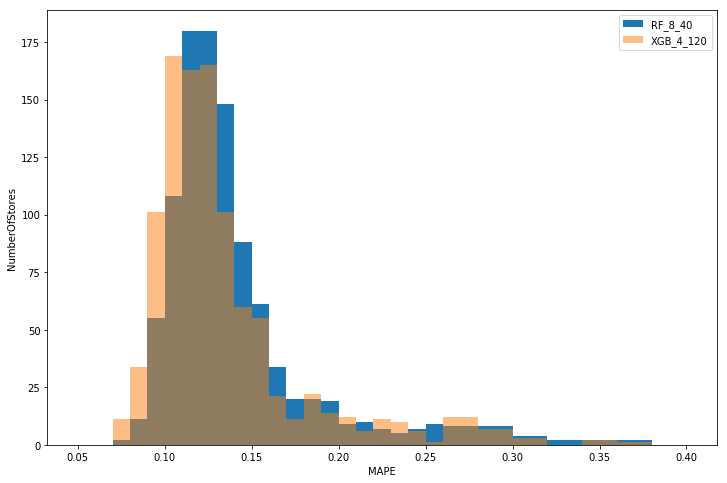

In [16]:
# Store Mapes Histogram For Store with over 600 days of traffic data.

df_xgb = pd.read_csv('All_Mapes_rf_8_40.csv')
df_rf = pd.read_csv('All_Mapes_xgb_4_120.csv')

bins_0_1 = [0.05,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,
                                  0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.28,0.3,0.32,0.34,
                                  0.36,0.38,0.40,0.42,0.44,0.46,0.48,0.5,0.55,0.6,0.65,0.7,0.8,0.9,1.0]

bins_0_04 = [0.05,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,
                                  0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.28,0.3,0.32,0.34,
                                  0.36,0.38,0.40]
    
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
counts, bins, fig = ax1.hist(df_xgb.mapes, 
                            bins=bins_0_04)
counts, bins, fig = ax1.hist(df_rf.mapes, 
                            bins=bins_0_04,
                            alpha=0.5)

ax1.set_xlabel('MAPE')
ax1.set_ylabel('NumberOfStores')
ax1.legend(['RF_8_40', 'XGB_4_120'])
plt.savefig('Store_mapes_hist.png')

In [17]:
df_xgb[df_xgb.mapes>0.4]

,Unnamed: 0,mapes,stores
263,263,2.242494,381
297,297,0.441557,427
415,415,0.491013,565
637,637,0.490457,1016
664,664,0.814054,1049
964,964,1.043401,1476


In [18]:
df_rf[df_rf.mapes>0.4]

,Unnamed: 0,mapes,stores
263,263,2.215513,381
297,297,0.443926,427
415,415,0.478751,565
637,637,0.492297,1016
664,664,0.798934,1049
782,782,0.402986,1195
964,964,1.007180,1476
